<a href="https://colab.research.google.com/github/Jan2309jr/csat-prediction/blob/main/csat_score_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSAT Score Prediction usinf Masked Flipkart Dataset

# Project Summary

**Customer Satisfaction** (CSAT) is a crucial performance metric in customer service that reflects how well customer queries and issues are addressed. This project focuses on building a machine learning pipeline to predict CSAT scores using a masked customer support dataset from Flipkart. The aim was to understand the key factors that influence customer satisfaction and develop a predictive model that can help businesses proactively identify areas of concern and improve customer experience.
Data Exploration and Preprocessing

The **dataset** included over 85,000 customer support interactions, each described by multiple features such as the communication channel (channel_name), the nature of the issue (category and Sub-category), timestamps for events (Issue_reported at, issue_responded, Survey_response_Date), agent details (Agent_name, Supervisor, Manager, Agent Shift, Tenure Bucket), and the target variable: CSAT Score. The CSAT score, ranging from 1 to 5, was treated as a categorical numeric variable, making this a multi-class classification problem.

Initial **exploration** revealed several challenges in the dataset, such as missing values, irrelevant features (e.g., Customer Remarks, Customer_City), and inconsistencies in date-time formats. One of the key feature engineering tasks involved creating a new feature called Response Time by calculating the difference between the time an issue was reported and the time it was responded to. This numeric feature was particularly valuable in understanding how prompt responses influence satisfaction levels.

To ensure reliable model training, **outliers** in the Response Time feature were identified and treated appropriately. Additionally, several categorical features such as channel_name, category, Agent Shift, and Supervisor were encoded to make them suitable for machine learning models.
Handling Class Imbalance

One of the most significant challenges was the highly **imbalanced distribution** of CSAT scores. A large majority of records had a CSAT score of 5, indicating general customer satisfaction, but this imbalance made it difficult for models to learn meaningful patterns for the minority classes (scores 1 to 4). To address this, data balancing techniques were applied to ensure that the classifier had a fair representation of all CSAT score classes during training.
Model Development

Three different **machine learning classification models** were used in this project: Random Forest, LightGBM, and CatBoost. All models were trained and evaluated using standard practices, including train-test splits and performance metrics like accuracy. Special care was taken to tune model hyperparameters for better generalization.

The **Random Forest Classifier**, known for its robustness and ability to handle noisy data, was selected as the final model due to its relatively consistent performance. CatBoost and LightGBM also performed comparably, but none of the models surpassed an accuracy of 0.69. Despite various tuning and balancing efforts, the nature of the data—especially the dominance of class 5—limited the overall predictive performance. Nonetheless, a 69% accuracy was a reasonable outcome given the real-world complexity of customer satisfaction prediction.
Deployment with Streamlit

To make the model accessible and interpretable, a user-friendly web interface was developed using **Streamlit**. The interface allows users to input values for features such as channel_name, category, Supervisor, Agent Shift, Tenure Bucket, and Response Time, and get a real-time CSAT score prediction. This interactive front-end bridges the gap between data science and business use, enabling decision-makers to assess potential satisfaction outcomes based on input conditions.
Conclusion

In conclusion, this project demonstrated the practical application of machine learning in predicting CSAT scores from a complex customer service dataset. It involved comprehensive data cleaning, feature engineering, outlier handling, class imbalance treatment, and model comparison. Although the model accuracy plateaued around 69%, the insights gained and the deployed application offer valuable groundwork for further improvements. Future steps could include incorporating NLP analysis of customer remarks, using ensemble techniques, and gathering additional data to enhance model performance. This project not only serves as a predictive tool but also offers strategic insights into the dynamics of customer satisfaction in a real-world support setting.

#GitHub Link - [CSAT-Score-Prediction](https://github.com/Jan2309jr/csat-prediction.git)


#Problem Statement

Customer satisfaction is a critical metric for evaluating the effectiveness of customer support operations. Flipkart, as a leading e-commerce platform, handles a high volume of customer queries through various channels such as calls, chats, and emails. Accurately predicting Customer Satisfaction (CSAT) scores can help the company identify service gaps, improve agent performance, and enhance overall customer experience.

This project aims to build a machine learning model that predicts the CSAT score (on a scale of 1 to 5) for a given customer interaction based on historical data. The dataset includes features such as the issue category, response time, agent and supervisor details, shift timings, and more. The goal is to use this data to anticipate customer satisfaction outcomes and provide actionable insights for proactive support strategy improvements.

# 1. Know Your Data

##Import Libraries

In [ ]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pickle
import joblib
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##Dataset Loading

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/Jan2309jr/csat-prediction/refs/heads/main/Customer_support_data.csv")

##Dataset First View

In [ ]:
df.head(10)

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5
5,1cfde5b9-6112-44fc-8f3b-892196137a62,Email,Returns,Fraudulent User,NaN,a2938961-2833-45f1-83d6-678d9555c603,NaN,01/08/2023 15:13,01/08/2023 18:39,01-Aug-23,NaN,NaN,NaN,NaN,Desiree Newton,Emma Park,John Smith,0-30,Morning,5
6,11a3ffd8-1d6b-4806-b198-c60b5934c9bc,Outcall,Product Queries,Product Specific Information,NaN,bfcb562b-9a2f-4cca-aa79-fd4e2952f901,NaN,01/08/2023 15:31,01/08/2023 23:52,01-Aug-23,NaN,NaN,NaN,NaN,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,5
7,372b51a5-fa19-4a31-a4b8-a21de117d75e,Inbound,Returns,Exchange / Replacement,Very good,88537e0b-5ffa-43f9-bbe2-fe57a0f4e4ae,NaN,01/08/2023 16:17,01/08/2023 16:23,01-Aug-23,NaN,NaN,NaN,NaN,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,5
8,6e4413db-4e16-42fc-ac92-2f402e3df03c,Inbound,Returns,Missing,Shopzilla app and it's all coustomer care serv...,e6be9713-13c3-493c-8a91-2137cbbfa7e6,NaN,01/08/2023 21:03,01/08/2023 21:07,01-Aug-23,NaN,NaN,NaN,NaN,David Smith,Nathan Patel,John Smith,>90,Split,5
9,b0a65350-64a5-4603-8b9a-a24a4a145d08,Inbound,Shopzilla Related,General Enquiry,NaN,c7caa804-2525-499e-b202-4c781cb68974,NaN,01/08/2023 23:31,01/08/2023 23:36,01-Aug-23,NaN,NaN,NaN,NaN,Tabitha Ayala,Amelia Tanaka,Michael Lee,31-60,Evening,5


##Dataset Rows & Columns count


In [ ]:
rows,cols=df.shape
print("Number of rows:",rows)
print("Number of columns:",cols)

Number of rows: 85907
Number of columns: 20


##Dataset Information


In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

###Duplicate Values


In [ ]:
df.duplicated().sum()

np.int64(0)

###Missing Values/Null Values

In [ ]:
#missing values count
df.isnull().sum()

Unique id                      0
channel_name                   0
category                       0
Sub-category                   0
Customer Remarks           57165
Order_id                   18232
order_date_time            68693
Issue_reported at              0
issue_responded                0
Survey_response_Date           0
Customer_City              68828
Product_category           68711
Item_price                 68701
connected_handling_time    85665
Agent_name                     0
Supervisor                     0
Manager                        0
Tenure Bucket                  0
Agent Shift                    0
CSAT Score                     0
dtype: int64

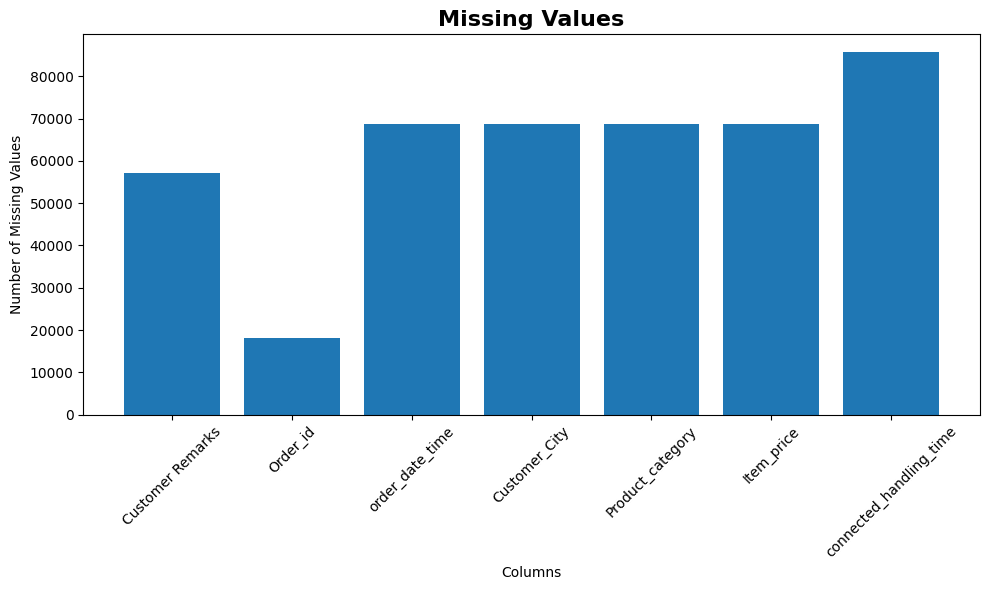

In [ ]:
# visualization of missing values
missing_cols = df.columns[df.isnull().any()]
missing_counts = df[missing_cols].isnull().sum()
plt.figure(figsize=(10, 6))
plt.bar(missing_cols, missing_counts)
plt.title("Missing Values", fontsize=16, fontweight='bold')
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##What did you know about your dataset?

The dataset contained 85,907 customer support records across 20 columns, with no duplicate entries. Key fields like channel_name, category, Agent_name, Supervisor, Agent Shift, and CSAT Score were complete and usable. However, several columns had significant missing values—Customer Remarks, Order_id, order_date_time, Customer_City, and connected_handling_time were notably sparse. Only a few numeric fields existed, and most data was categorical. A custom Response Time feature was engineered from time-related columns. Overall, while rich in categorical insights, the dataset required substantial cleaning and feature engineering to become model-ready due to its sparsity and limited usable numeric data.

#2. Understanding Your Variables

## Dataset Columns

In [ ]:
df.columns.to_list()

['Unique id',
 'channel_name',
 'category',
 'Sub-category',
 'Customer Remarks',
 'Order_id',
 'order_date_time',
 'Issue_reported at',
 'issue_responded',
 'Survey_response_Date',
 'Customer_City',
 'Product_category',
 'Item_price',
 'connected_handling_time',
 'Agent_name',
 'Supervisor',
 'Manager',
 'Tenure Bucket',
 'Agent Shift',
 'CSAT Score']

## Dataset Describe

In [ ]:
df.describe()

,Item_price,connected_handling_time,CSAT Score
count,17206.000000,242.000000,85907.000000
mean,5660.774846,462.400826,4.242157
std,12825.728411,246.295037,1.378903
min,0.000000,0.000000,1.000000
25%,392.000000,293.000000,4.000000
50%,979.000000,427.000000,5.000000
75%,2699.750000,592.250000,5.000000
max,164999.000000,1986.000000,5.000000


## Variables Description

In [ ]:
print(pd.DataFrame({
    "Data Type": df.dtypes,
    "Uniques values": df.nunique(),
    "Null values": df.isnull().sum()
}))

                        Data Type  Uniques values  Null values
Unique id                  object           85907            0
channel_name               object               3            0
category                   object              12            0
Sub-category               object              57            0
Customer Remarks           object           18231        57165
Order_id                   object           67675        18232
order_date_time            object           13766        68693
Issue_reported at          object           30923            0
issue_responded            object           30262            0
Survey_response_Date       object              31            0
Customer_City              object            1782        68828
Product_category           object               9        68711
Item_price                float64            2789        68701
connected_handling_time   float64             211        85665
Agent_name                 object            1371      

##Unique Values for each variable.

In [ ]:
for col in df.columns:
    print(f"\nColumn: {col}, No of unique values:{df[col].nunique()}")
    print(df[col].unique())


Column: Unique id, No of unique values:85907
['7e9ae164-6a8b-4521-a2d4-58f7c9fff13f'
 'b07ec1b0-f376-43b6-86df-ec03da3b2e16'
 '200814dd-27c7-4149-ba2b-bd3af3092880' ...
 '723bce2c-496c-4aa8-a64b-ca17004528f0'
 '707528ee-6873-4192-bfa9-a491f1c08ab5'
 '07c7a878-0d5a-42e0-97ef-de59abec0238']

Column: channel_name, No of unique values:3
['Outcall' 'Inbound' 'Email']

Column: category, No of unique values:12
['Product Queries' 'Order Related' 'Returns' 'Cancellation'
 'Shopzilla Related' 'Payments related' 'Refund Related' 'Feedback'
 'Offers & Cashback' 'Onboarding related' 'Others' 'App/website']

Column: Sub-category, No of unique values:57
['Life Insurance' 'Product Specific Information' 'Installation/demo'
 'Reverse Pickup Enquiry' 'Not Needed' 'Fraudulent User'
 'Exchange / Replacement' 'Missing' 'General Enquiry' 'Return request'
 'Delayed' 'Service Centres Related' 'Payment related Queries'
 'Order status enquiry' 'Return cancellation' 'Unable to track'
 'Seller Cancelled Order' 'W


Column: Customer Remarks, No of unique values:18231
[nan 'Very good'
 "Shopzilla app and it's all coustomer care services is very good service provided all time"
 ...
 "Trough the Shopzilla App Refunding Policy should be easier and stepwise successful so that a customer need not communicate with the customer care; 'Return and Refund' must be 100% feasible through the App."
 'Supported team customer executive   good'
 'need to improve with proper details.']

Column: Order_id, No of unique values:67675
['c27c9bb4-fa36-4140-9f1f-21009254ffdb'
 'd406b0c7-ce17-4654-b9de-f08d421254bd'
 'c273368d-b961-44cb-beaf-62d6fd6c00d5' ...
 'bdefe788-ccec-4eda-8ca4-51045e68db8a'
 'a031ec28-0c5e-450e-95b2-592342c40bc4'
 '3230db30-f8da-4c44-8636-ec76d1d3d4f3']

Column: order_date_time, No of unique values:13766
[nan '19/07/2023 23:50' '06/05/2023 21:41' ... '14/08/2023 23:11'
 '14/08/2023 18:43' '28/08/2023 18:48']

Column: Issue_reported at, No of unique values:30923
['01/08/2023 11:13' '01/08/2023 12:5

#3. Data Wrangling

##1.Handling Missing Values

In [ ]:
df.isnull().sum()

Unique id                      0
channel_name                   0
category                       0
Sub-category                   0
Customer Remarks           57165
Order_id                   18232
order_date_time            68693
Issue_reported at              0
issue_responded                0
Survey_response_Date           0
Customer_City              68828
Product_category           68711
Item_price                 68701
connected_handling_time    85665
Agent_name                     0
Supervisor                     0
Manager                        0
Tenure Bucket                  0
Agent Shift                    0
CSAT Score                     0
dtype: int64

In [ ]:
#removing columns with too many missing/null values
null_cols=["Customer Remarks","Order_id","order_date_time","Customer_City","Product_category","Item_price","connected_handling_time"]
for col in null_cols:
  df.drop(columns=[col],inplace=True, axis=1)

##2.Removing irrelevant data columns

In [ ]:
df.drop(columns=["Unique id"],inplace=True,axis=1)

##3.Parsing Data

In [ ]:
# Convert columns to datetime
df['Issue_reported at'] = pd.to_datetime(df['Issue_reported at'], format='%d/%m/%Y %H:%M', errors='coerce')
df['issue_responded'] = pd.to_datetime(df['issue_responded'], format='%d/%m/%Y %H:%M', errors='coerce')
#convert column to date
df['Survey_response_Date'] = pd.to_datetime(df['Survey_response_Date'], format='%d-%b-%y', errors='coerce')

##4.Standardizing/Formatting





In [ ]:
cols = df.columns
df.columns = [
    ' '.join(word.capitalize() for word in col.strip().replace('_', ' ').replace('-', ' ').split())
    for col in cols
]

##5.Adding new column (feature manipulation)

In [ ]:
df["Response Time"]=(df["Issue Responded"]-df["Issue Reported At"]).dt.total_seconds()/3600

In [ ]:
print(f"Max value in Reponds Time:{df['Response Time'].max()}")
print(f"Min value in Reponds Time:{df['Response Time'].min()}")

Max value in Reponds Time:95.96666666666667
Min value in Reponds Time:-23.95


In [ ]:
# Filter rows with negative Resolve_time
negative_resolve_df = df[df['Response Time'] < 0][['Issue Responded', 'Issue Reported At', 'Response Time']]

# Show the
negative_resolve_df

,Issue Responded,Issue Reported At,Response Time
74172,2023-08-28,2023-08-28 16:07:00,-16.116667
74173,2023-08-28,2023-08-28 16:56:00,-16.933333
74174,2023-08-28,2023-08-28 20:14:00,-20.233333
74175,2023-08-28,2023-08-28 14:37:00,-14.616667
74176,2023-08-28,2023-08-28 23:26:00,-23.433333
...,...,...,...
77566,2023-08-28,2023-08-28 13:25:00,-13.416667
77567,2023-08-28,2023-08-28 18:09:00,-18.150000
77568,2023-08-28,2023-08-28 22:20:00,-22.333333
77569,2023-08-28,2023-08-28 14:38:00,-14.633333


##5.Fixing corrupt rows

In [ ]:
# Step 1: Calculate mean of only valid (positive) Response Time
mean_respond_time = df[df['Response Time'] > 0]['Response Time'].mean()

# Step 2: Replace negative values with this mean
df.loc[df['Response Time'] < 0, 'Response Time'] = mean_respond_time

# Optional: round it again if needed
df['Response Time'] = df['Response Time'].round(2)

# Check to confirm no more negative values
print(df['Response Time'].min())

0.0


In [ ]:
#dropping columns not required
df.drop(['Issue Responded','Issue Reported At'],  axis = 1, inplace = True)

In [ ]:
df.head()

,Channel Name,Category,Sub Category,Survey Response Date,Agent Name,Supervisor,Manager,Tenure Bucket,Agent Shift,Csat Score,Response Time
0,Outcall,Product Queries,Life Insurance,2023-08-01,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,0.57
1,Outcall,Product Queries,Product Specific Information,2023-08-01,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,0.03
2,Inbound,Order Related,Installation/demo,2023-08-01,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,0.37
3,Inbound,Returns,Reverse Pickup Enquiry,2023-08-01,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,0.33
4,Inbound,Cancellation,Not Needed,2023-08-01,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,0.03




---



#What all manipulations have you done and insights you found?

To prepare the dataset for modeling, I began by removing columns with excessive missing values such as Customer Remarks, Item_price, and Customer_City. Irrelevant fields like Unique id were dropped. I then parsed date-time columns and engineered a new numerical feature called Response Time, calculated from the time difference between issue reporting and resolution. Negative values in this feature were replaced with the mean response time. Columns were renamed for consistency. These manipulations revealed that longer response times may impact satisfaction, and that the majority of interactions had a CSAT score of 5, indicating a significant class imbalance.



---



#4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables

##Chart - 1

### CSAT Score distribution bar graph

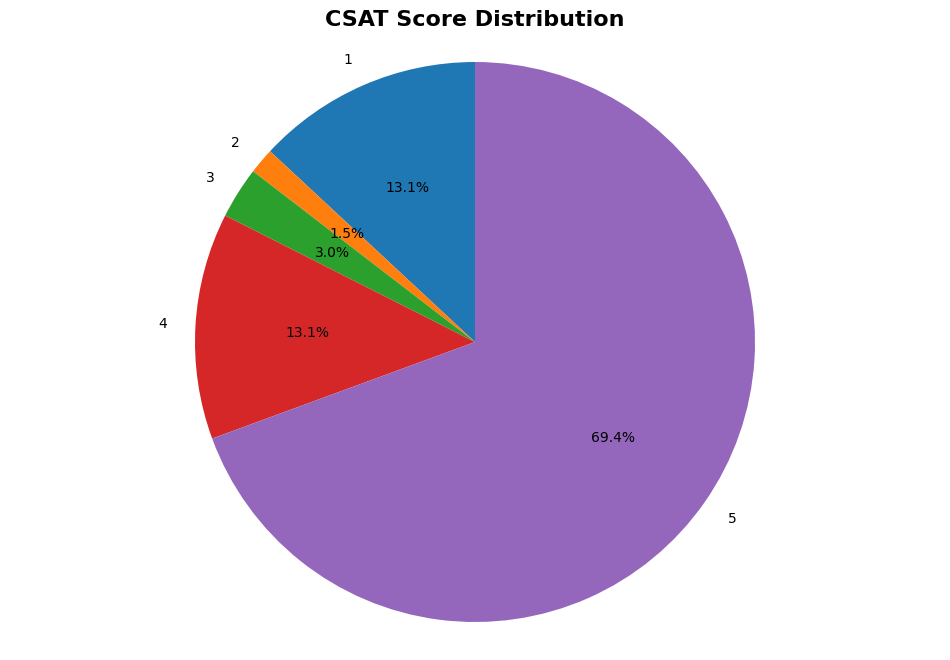

In [ ]:
csat_counts = df['Csat Score'].value_counts().sort_index()
# Plot pie chart
plt.figure(figsize=(12,8))
plt.pie(csat_counts, labels=csat_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("CSAT Score Distribution", fontsize=16, fontweight='bold')
plt.axis('equal')  # Keeps the pie chart circular
plt.show()

###1. Why did you pick the specific chart?

I chose a pie chart because it effectively represents proportional distribution, making it easier to visualize the imbalance among CSAT score categories. It highlights which scores dominate and which are underrepresented at a glance, which is crucial when analyzing class imbalance in classification problems.

###2. What is/are the insight(s) found from the chart?

The chart reveals that CSAT score 5 accounts for 69.4% of the data, showing a strong bias toward high satisfaction. In contrast, scores 1 and 2 make up a very small portion (just 1.5% and 3.0%), indicating underrepresentation of dissatisfied customers. This confirms the severe class imbalance, which could impact model performance.

###3. Will the gained insights help create a positive business impact?

Yes. Understanding the CSAT imbalance helps businesses identify blind spots most models may overpredict score 5 and miss early warning signs from dissatisfied customers. By addressing this, businesses can improve customer retention by focusing on cases that lead to poor satisfaction.



---



##Chart - 2

### Agent shift and csat score relation

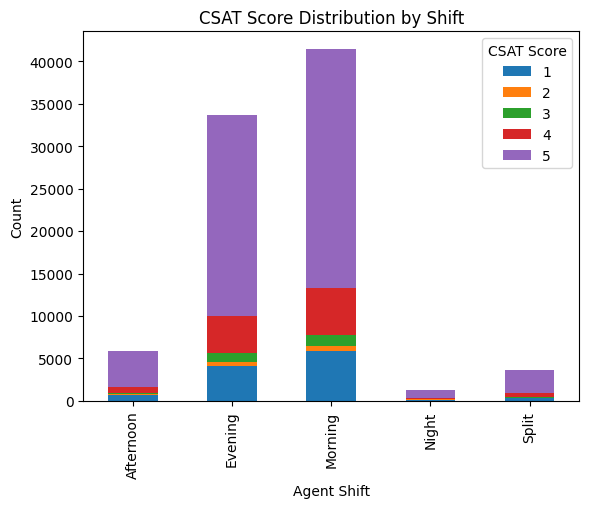

In [ ]:
csat_by_shift = pd.crosstab(df['Agent Shift'], df['Csat Score'])
csat_by_shift.plot(kind='bar', stacked=True)
plt.title("CSAT Score Distribution by Shift")
plt.xlabel("Agent Shift")
plt.ylabel("Count")
plt.legend(title="CSAT Score")
plt.show()



---



##Chart - 3

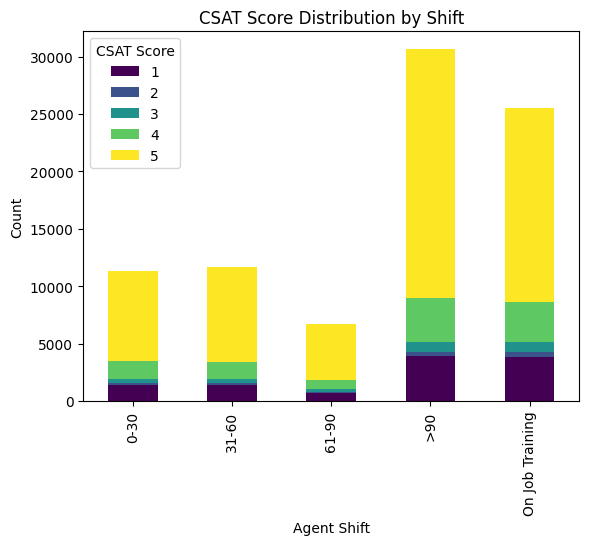

In [ ]:
csat_by_shift = pd.crosstab(df['Tenure Bucket'], df['Csat Score'])
csat_by_shift.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("CSAT Score Distribution by Shift")
plt.xlabel("Agent Shift")
plt.ylabel("Count")
plt.legend(title="CSAT Score")
plt.show()



---



##Chart - 4

###Channel type used

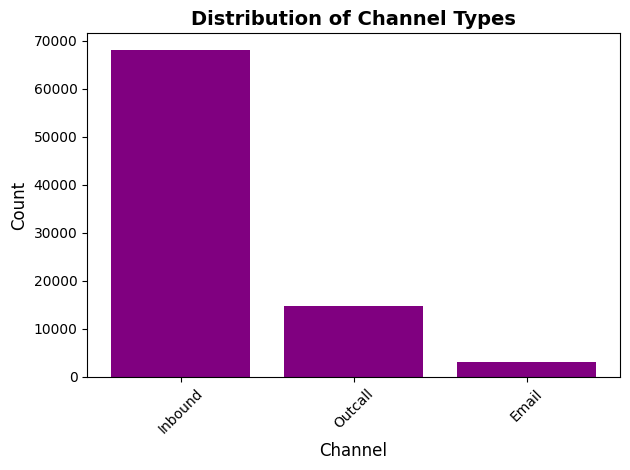

In [ ]:
# Count each channel type
channel_counts = df['Channel Name'].value_counts()

# Plot bar chart
plt.bar(channel_counts.index, channel_counts.values,color="purple")
plt.title('Distribution of Channel Types', fontsize=14, fontweight='bold')
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



---



##Chart - 5

### shift and channel

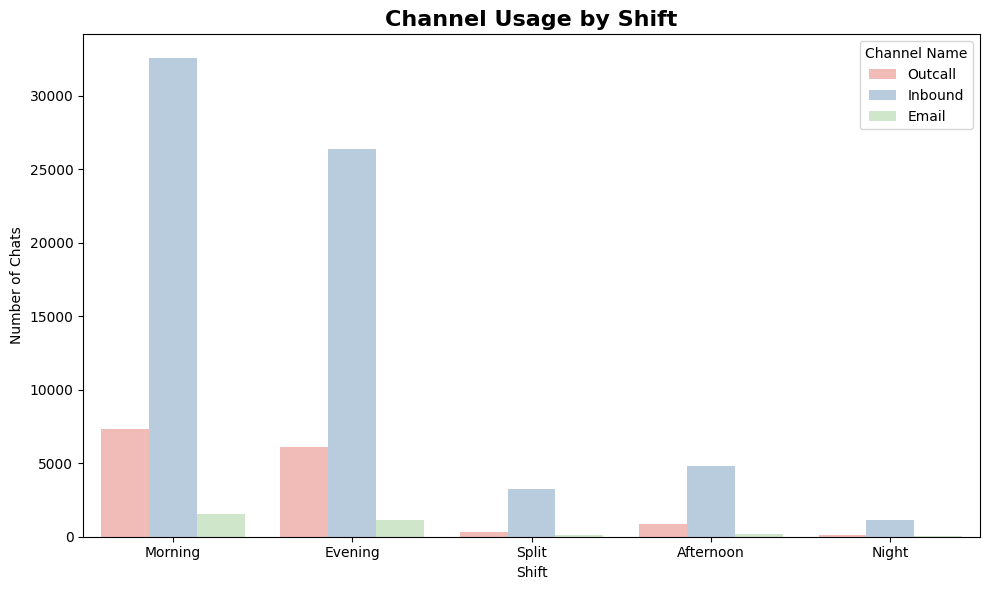

In [ ]:
plt.figure(figsize=(10, 6))
sb.countplot(
    data=df,
    x='Agent Shift',
    hue='Channel Name',
    palette='Pastel1'
)
plt.title('Channel Usage by Shift', fontsize=16, fontweight='bold')
plt.xlabel('Shift')
plt.ylabel('Number of Chats')
plt.xticks(rotation=0)
# Optional: move legend to top
plt.tight_layout()
plt.show()




---



##Chart - 6

### channel used,agenet,csat score

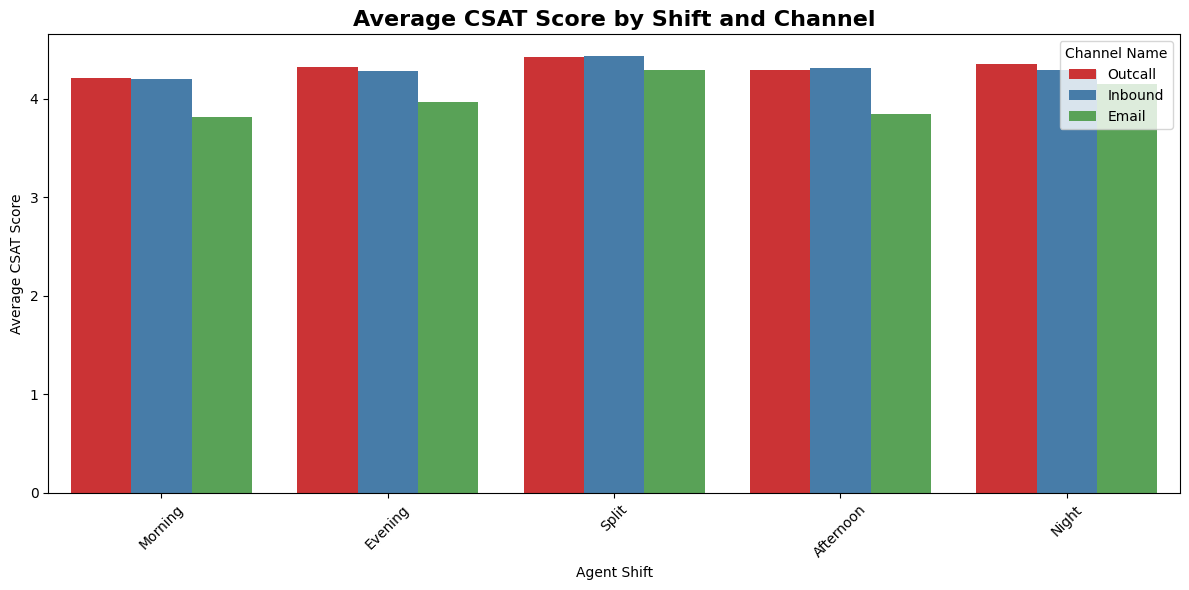

In [ ]:
plt.figure(figsize=(12, 6))
sb.barplot(data=df, x='Agent Shift', y='Csat Score', hue='Channel Name', errorbar=None, palette="Set1")
plt.title('Average CSAT Score by Shift and Channel', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Average CSAT Score')
plt.xlabel('Agent Shift')
plt.tight_layout()
plt.show()



---



##Chart - 7

### supervisor vs csat score

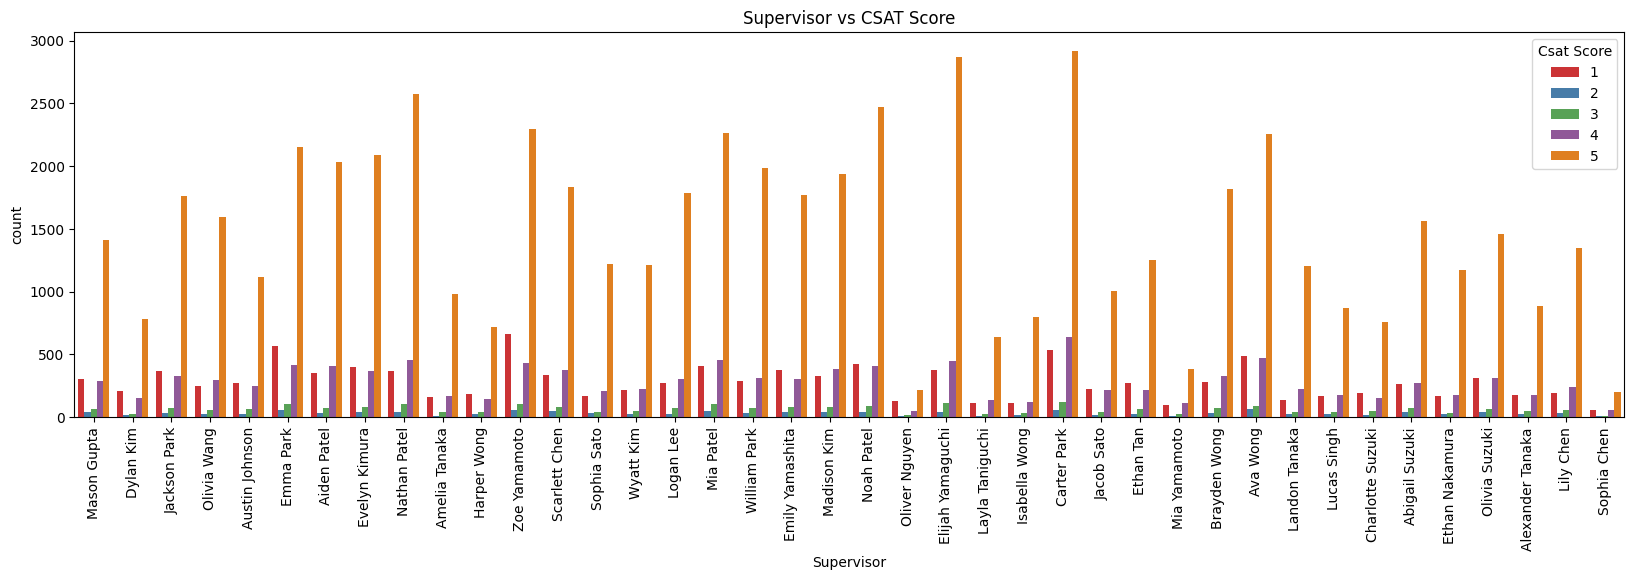

In [ ]:
plt.figure(figsize=(20, 5))
sb.countplot(x='Supervisor', hue='Csat Score', data=df,palette='Set1')
plt.title('Supervisor vs CSAT Score')
plt.xticks(rotation=90)
plt.show()



---



##Chart - 8

### Manager vs CSAT Score

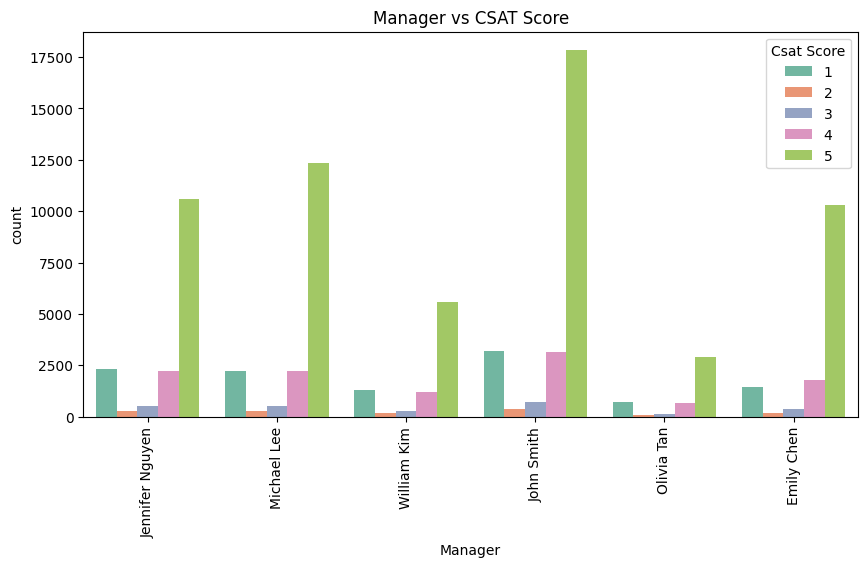

In [ ]:
plt.figure(figsize=(10, 5))
sb.countplot(x='Manager', hue='Csat Score', data=df,palette='Set2')
plt.title('Manager vs CSAT Score')
plt.xticks(rotation=90)
plt.show()



---



##Chart - 9

### Responds Time and csat score

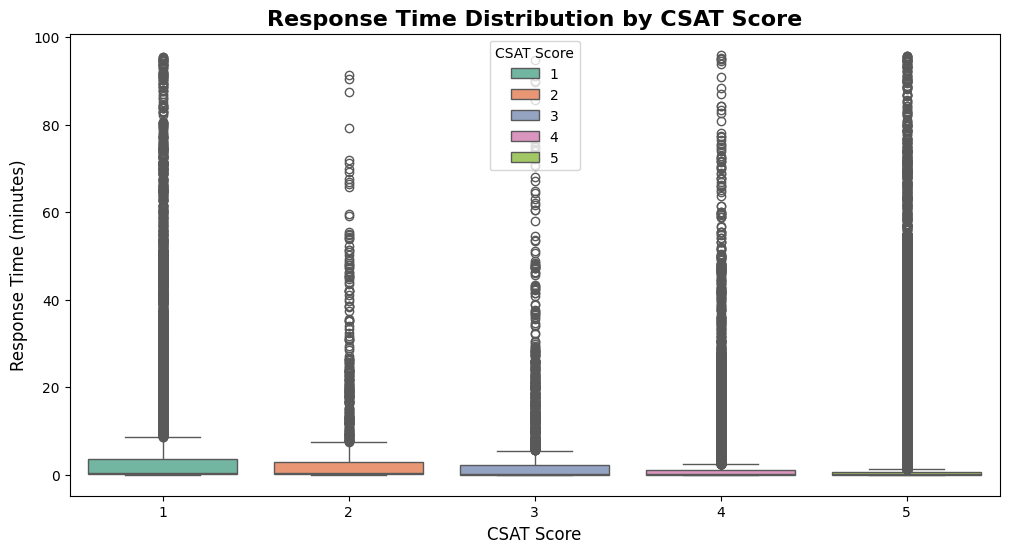

In [ ]:

temp_df = pd.DataFrame({
    'Response Time (min)': df["Response Time"],
    'CSAT Score': df['Csat Score']
})

temp_df = temp_df[temp_df['Response Time (min)'] < 120]
plt.figure(figsize=(12, 6))
sb.boxplot(data=temp_df, x='CSAT Score', y='Response Time (min)',hue="CSAT Score", palette='Set2')
plt.title('Response Time Distribution by CSAT Score', fontsize=16, fontweight='bold')
plt.xlabel('CSAT Score', fontsize=12)
plt.ylabel('Response Time (minutes)', fontsize=12)
plt.show()



---



##Chart - 10

### Sub cat and csat

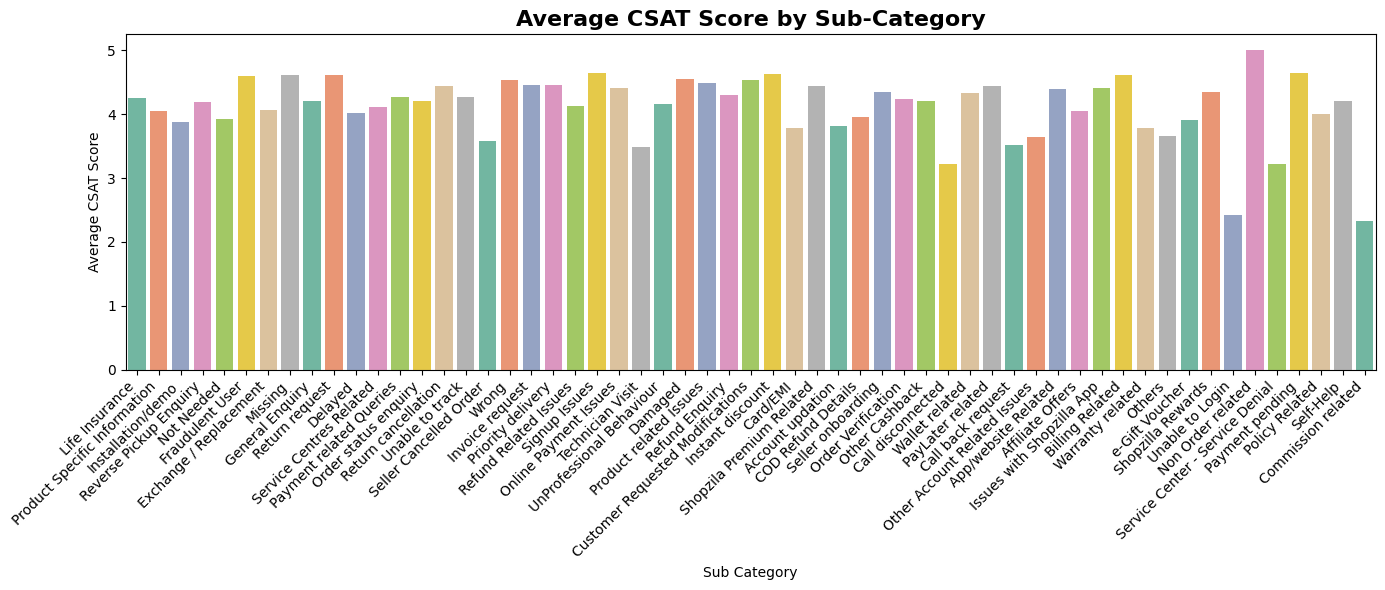

In [ ]:
plt.figure(figsize=(14, 6))
sb.barplot(data=df, x='Sub Category', y='Csat Score',hue="Sub Category", errorbar=None, palette='Set2')

plt.title('Average CSAT Score by Sub-Category', fontsize=16, fontweight='bold')
plt.xlabel('Sub Category')
plt.ylabel('Average CSAT Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



---



##Chart - 11

### category vs csat

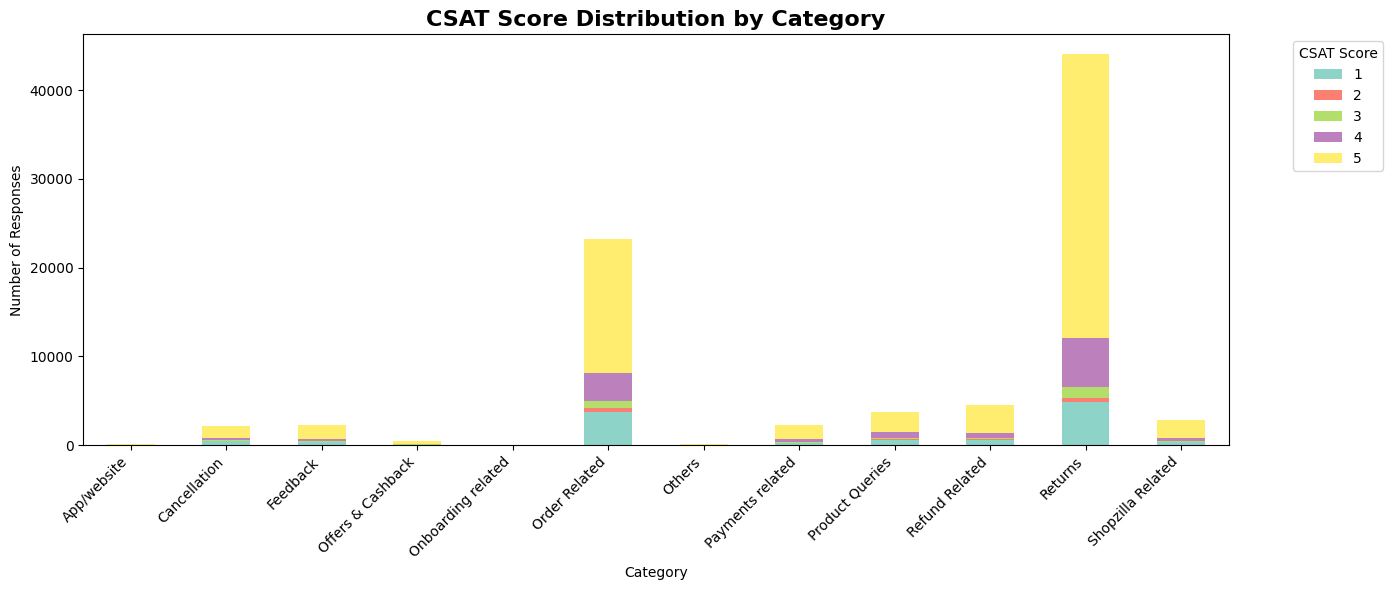

In [ ]:

# Step 1: Create a frequency table
csat_dist = pd.crosstab(df['Category'], df['Csat Score'])

# Step 2: Plot as stacked bar chart
csat_dist.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set3')

# Step 3: Customize the plot
plt.title('CSAT Score Distribution by Category', fontsize=16, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45, ha='right')
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



---



##Chart - 12

### Survey response day vs csat score

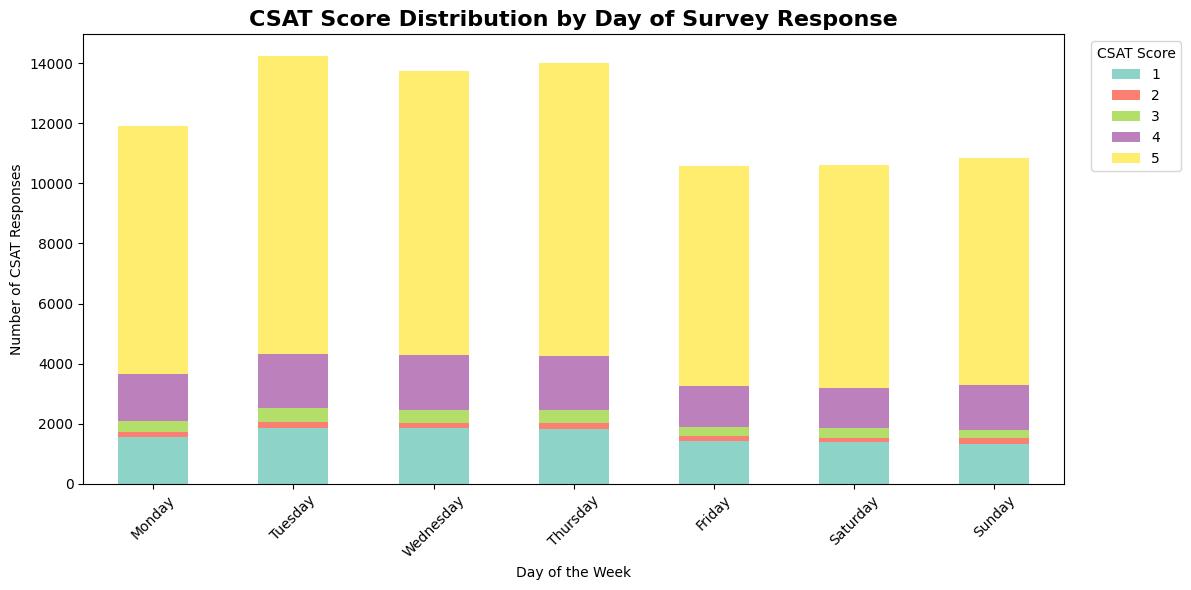

In [ ]:
# Step 1: Convert survey response date to weekday name (in memory)
day_names = df['Survey Response Date'].dt.day_name()

# Step 2: Build a crosstab of CSAT score counts per day
csat_dist_by_day = pd.crosstab(day_names, df['Csat Score'])

# Step 3: Reorder rows so days are in correct week order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
csat_dist_by_day = csat_dist_by_day.reindex(ordered_days)

# Step 4: Plot stacked bar chart
csat_dist_by_day.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')

plt.title('CSAT Score Distribution by Day of Survey Response', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week')
plt.ylabel('Number of CSAT Responses')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



---



##Chart - 13

survey day and agent shift

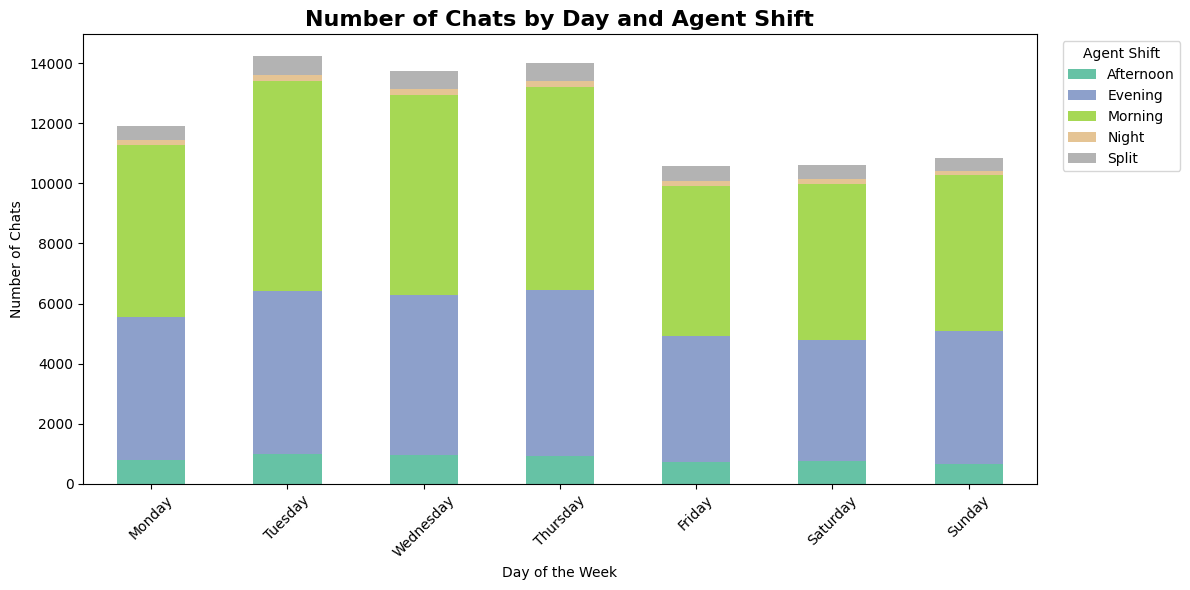

In [ ]:
# Step 1: Convert survey date to weekday name (in memory)
day_names = df['Survey Response Date'].dt.day_name()

# Step 2: Build temporary DataFrame
temp_df = pd.DataFrame({
    'Day': day_names,
    'Shift': df['Agent Shift']
})

# Step 3: Crosstab: how many chats per (Day, Shift)
day_shift_counts = pd.crosstab(temp_df['Day'], temp_df['Shift'])

# Step 4: Reorder days for consistent weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_shift_counts = day_shift_counts.reindex(ordered_days)

# Step 5: Plot stacked bar chart
day_shift_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title('Number of Chats by Day and Agent Shift', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Chats')
plt.xticks(rotation=45)
plt.legend(title='Agent Shift', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



---



##Chart - 14 - Correlation Heatmap

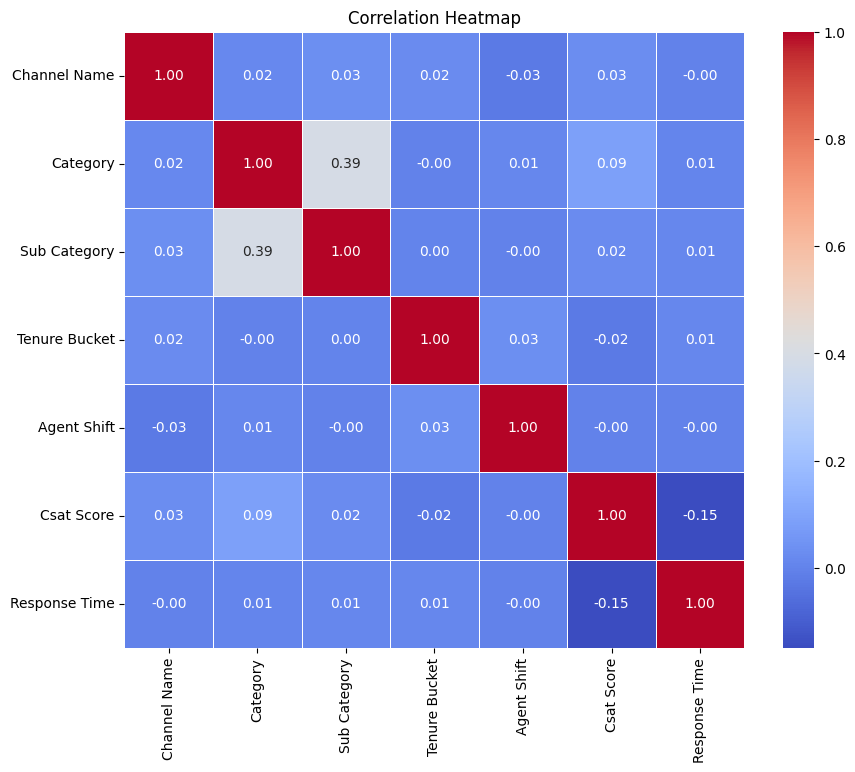

In [ ]:
# Take a small sample from the actual dataframe (like first 50000 rows)
df_sample = df.sample(n=50000, random_state=42)  # or df.head(50000)

# Optional: Drop columns that are not useful or too high cardinality
df_sample = df_sample.drop(columns=["Survey Response Date", "Agent Name", "Supervisor", "Manager"])
# Encode categorical features in memory
le = LabelEncoder()
for col in df_sample.select_dtypes(include='object').columns:
    df_sample[col] = le.fit_transform(df_sample[col])
# Compute correlation matrix
corr_matrix = df_sample.corr(numeric_only=True)
# Plot heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()



---



##Chart - 15 Pair Plot

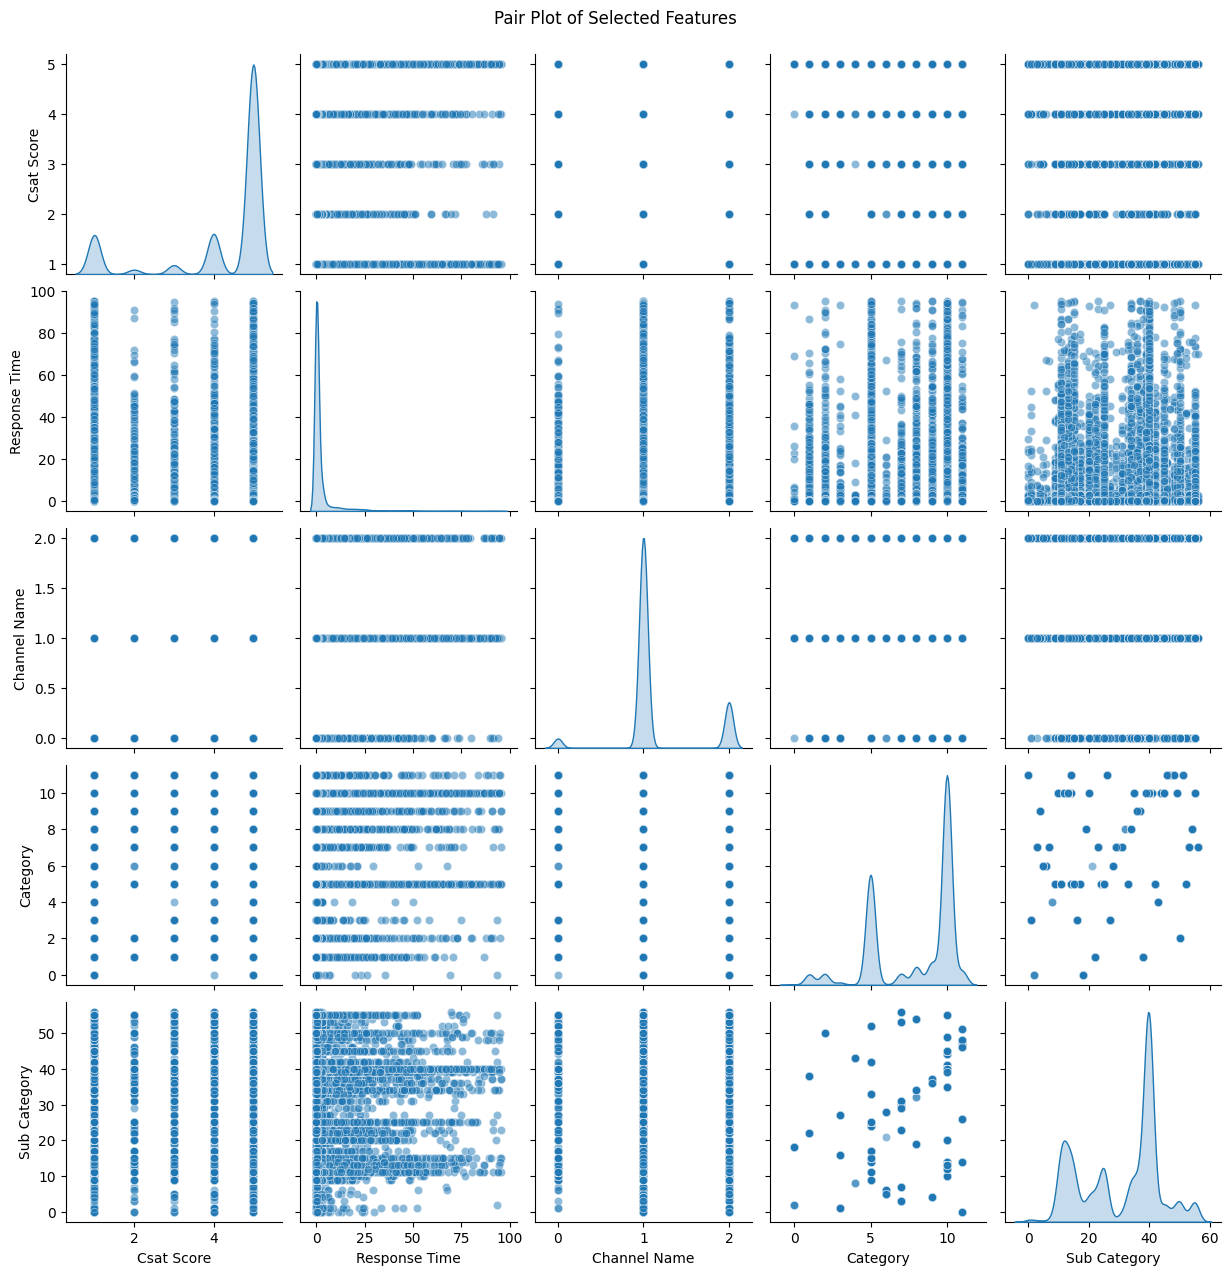

In [ ]:
# Sample 50000 rows
df_sample = df.sample(n=50000, random_state=42)

# Drop columns not useful for correlation analysis
df_sample = df_sample.drop(columns=["Survey Response Date", "Agent Name", "Supervisor", "Manager"])

# Encode categorical columns in memory
le = LabelEncoder()
for col in df_sample.select_dtypes(include='object').columns:
    df_sample[col] = le.fit_transform(df_sample[col])

# OPTIONAL: If there are too many features, select only the most relevant for pairplot
# For example: include only 'Csat Score', 'Response Time', and encoded 'Channel Name', etc.
selected_cols = ['Csat Score', 'Response Time'] + list(df_sample.select_dtypes(include='number').drop(columns=['Csat Score', 'Response Time']).columns[:3])  # limit to 5 cols
# Plot pairplot
sb.pairplot(df_sample[selected_cols], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()



---



#5. Hypothesis Testing

##  Hypothesis
1. Average CSAT score is significantly different on weekdays vs weekends.
2. CSAT score is balanced across all score values (i.e., uniform distribution).
3. There is a correlation between response time and CSAT score

##Average CSAT score is significantly different on weekdays vs weekends.

H0 (Null): Mean CSAT score is the same on weekdays and weekends.

H1 (Alt): Mean CSAT score is different between weekdays and weekends.

Test: Independent t-test

why? Comparing two independent groups (weekday vs weekend) on a numeric outcome (CSAT).

In [ ]:
from scipy.stats import ttest_ind

# Convert date to day
df['Survey Response Date'] = pd.to_datetime(df['Survey Response Date'], errors='coerce')
df['Day'] = df['Survey Response Date'].dt.day_name()

# Weekday or Weekend
df['Week Type'] = df['Day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

weekday_scores = df[df['Week Type'] == 'Weekday']['Csat Score'].dropna()
weekend_scores = df[df['Week Type'] == 'Weekend']['Csat Score'].dropna()

# T-test
t_stat, p_value = ttest_ind(weekday_scores, weekend_scores, equal_var=False)
print(f"H1: p-value = {p_value:.4f}")

H1: p-value = 0.0526


Feature Manipulation done here in order to get survey response day

In [ ]:
df.head()

,Channel Name,Category,Sub Category,Survey Response Date,Agent Name,Supervisor,Manager,Tenure Bucket,Agent Shift,Csat Score,Response Time,Day,Week Type
0,Outcall,Product Queries,Life Insurance,2023-08-01,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,0.57,Tuesday,Weekday
1,Outcall,Product Queries,Product Specific Information,2023-08-01,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,0.03,Tuesday,Weekday
2,Inbound,Order Related,Installation/demo,2023-08-01,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,0.37,Tuesday,Weekday
3,Inbound,Returns,Reverse Pickup Enquiry,2023-08-01,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,0.33,Tuesday,Weekday
4,Inbound,Cancellation,Not Needed,2023-08-01,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,0.03,Tuesday,Weekday


**There is no strong statistical evidence that CSAT differs between weekdays and weekends.**

---



## CSAT score is balanced across all score values (i.e., uniform distribution).

H0: CSAT scores follow a uniform distribution (all scores equally likely).

H1: CSAT scores do not follow a uniform distribution.

Test: Chi-Square Goodness of Fit

Why: Checks if observed frequencies deviate from expected uniform frequencies.

In [ ]:
from scipy.stats import chisquare

csat_counts = df['Csat Score'].value_counts().sort_index()
expected = [csat_counts.sum() / len(csat_counts)] * len(csat_counts)

chi_stat, p_value = chisquare(f_obs=csat_counts, f_exp=expected)
print(f"H2: Chi-Square p-value = {p_value:.4f}")

H2: Chi-Square p-value = 0.0000


**CSAT scores are not uniformly distributed.**

---



##There is a correlation between response time and CSAT score.

H0: Response time is not correlated with CSAT score.

H1: There is a correlation between response time and CSAT score.

Test: Spearman or Pearson correlation

Why: If response time is not normally distributed, use Spearman.

In [ ]:
from scipy.stats import spearmanr

df_clean = df[['Response Time', 'Csat Score']].dropna()
corr, p_value = spearmanr(df_clean['Response Time'], df_clean['Csat Score'])
print(f"H3: Spearman Correlation = {corr:.3f}, p-value = {p_value:.4f}")


H3: Spearman Correlation = -0.175, p-value = 0.0000


**You reject the null hypothesis: there is a relationship.**

---



#6. Feature Engineering & Data Pre-processing

##1. Handling Missing Values

In [ ]:
df.isnull().sum()

Channel Name            0
Category                0
Sub Category            0
Survey Response Date    0
Agent Name              0
Supervisor              0
Manager                 0
Tenure Bucket           0
Agent Shift             0
Csat Score              0
Response Time           0
Day                     0
Week Type               0
dtype: int64

##2. Categorical Encoding

In [ ]:
#Identifying categorical data columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:")
for col in categorical_cols:
  print(col)

Categorical columns:
Channel Name
Category
Sub Category
Agent Name
Supervisor
Manager
Tenure Bucket
Agent Shift
Day
Week Type


In [ ]:
#creating copy of data
df_encoded = df.copy()

In [ ]:
categorical_cols = [
    'Channel Name', 'Category', 'Sub Category', 'Agent Name',
    'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
    'Day', 'Week Type'
]

In [ ]:
#Label encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save the encoder for later decoding
print(df_encoded[categorical_cols].head())

   Channel Name  Category  Sub Category  Agent Name  Supervisor  Manager  \
0             2         8            19        1072          26        1   
1             2         8            34        1323           9        3   
2             1         5            15         370          18        5   
3             1        10            40        1024          33        2   
4             1         1            22         247           4        3   

   Tenure Bucket  Agent Shift  Day  Week Type  
0              4            2    5          0  
1              3            2    5          0  
2              4            1    5          0  
3              3            1    5          0  
4              0            2    5          0  


In [ ]:
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [ ]:
df.head()

,Channel Name,Category,Sub Category,Survey Response Date,Agent Name,Supervisor,Manager,Tenure Bucket,Agent Shift,Csat Score,Response Time,Day,Week Type
0,Outcall,Product Queries,Life Insurance,2023-08-01,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,0.57,Tuesday,Weekday
1,Outcall,Product Queries,Product Specific Information,2023-08-01,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,0.03,Tuesday,Weekday
2,Inbound,Order Related,Installation/demo,2023-08-01,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,0.37,Tuesday,Weekday
3,Inbound,Returns,Reverse Pickup Enquiry,2023-08-01,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,0.33,Tuesday,Weekday
4,Inbound,Cancellation,Not Needed,2023-08-01,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,0.03,Tuesday,Weekday


In [ ]:
df_encoded[categorical_cols].head()

,Channel Name,Category,Sub Category,Agent Name,Supervisor,Manager,Tenure Bucket,Agent Shift,Day,Week Type
0,2,8,19,1072,26,1,4,2,5,0
1,2,8,34,1323,9,3,3,2,5,0
2,1,5,15,370,18,5,4,1,5,0
3,1,10,40,1024,33,2,3,1,5,0
4,1,1,22,247,4,3,0,2,5,0


##3. Handling Outliers

In [ ]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['Csat Score', 'Response Time'], dtype='object')

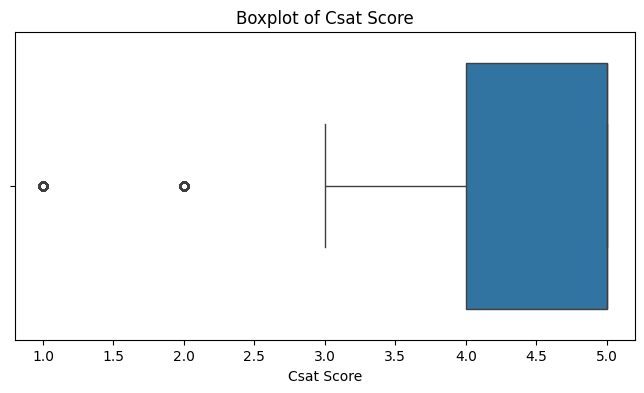

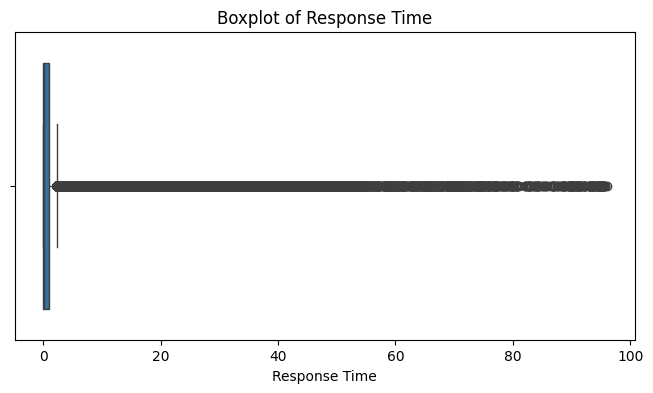

In [ ]:
max_before= df_encoded['Response Time'].max()
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sb.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
#detecting ouliers
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] < lower) | (data[col] > upper)]
#counting outliers for each columns
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

Csat Score: 12513 outliers
Response Time: 16360 outliers


In [ ]:
#csat will get balanced so need to handle outliers now
#capping reponse time to manage outliers
# Cap 'Response Time' at 1st and 99th percentile
q1 = df_encoded['Response Time'].quantile(0.01)
q99 = df_encoded['Response Time'].quantile(0.99)

print(f"Capping values outside: lower={q1}, upper={q99}")

# Apply capping
df_encoded['Response Time'] = df_encoded['Response Time'].clip(lower=q1, upper=q99)


Capping values outside: lower=0.0, upper=50.12


In [ ]:
# Check max before and after
print("Max before capping:", max_before)
print("Max after capping:", df_encoded['Response Time'].max())
print("Count > 50.12:", (df_encoded['Response Time'] > 50.12).sum())


Max before capping: 95.97
Max after capping: 50.12
Count > 50.12: 0


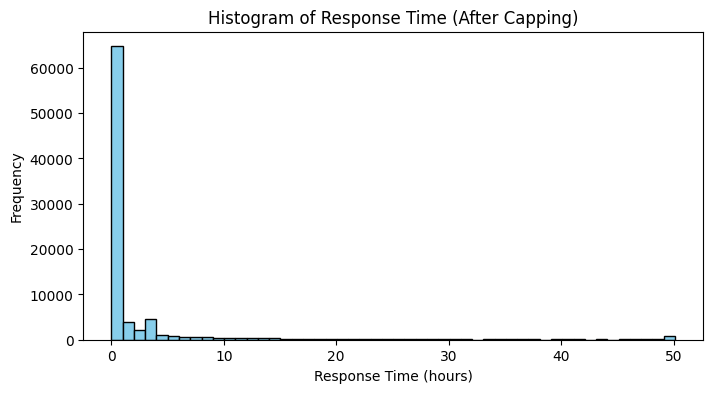

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df_encoded["Response Time"], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Response Time (After Capping)")
plt.xlabel("Response Time (hours)")
plt.ylabel("Frequency")
plt.show()
#since im using tree based model im not going to handle the right skew

## 5. Data Split

In [ ]:
X = df_encoded.drop(columns=['Csat Score', 'Survey Response Date'])  # drop target + datetime
y = df_encoded['Csat Score']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

##6. Handling Imbalanced Dataset

In [ ]:
df['Csat Score'].value_counts(normalize=True) * 100  # % class distribution

Csat Score
5    69.397139
1    13.072276
4    13.059471
3     2.977639
2     1.493476
Name: proportion, dtype: float64

In [ ]:
#using SMOT(oversampling)
# Drop datetime columns before SMOTE
X_train = X_train.select_dtypes(exclude=['datetime64[ns]'])
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

##7. Dropping irrelevant columns

In [ ]:
datetime_cols = X_train.select_dtypes(include='datetime64').columns #will be a problem will balancing using SMOT

## 7. Feature Manipulation & Selection

###1. Feature Manipulation

NOTE- Feature Manipulation has already been done in the previous sections

###2. Feature Selection

In [ ]:
#Feature Importance
model = LGBMClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 238465, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


LGBMClassifier(random_state=42)

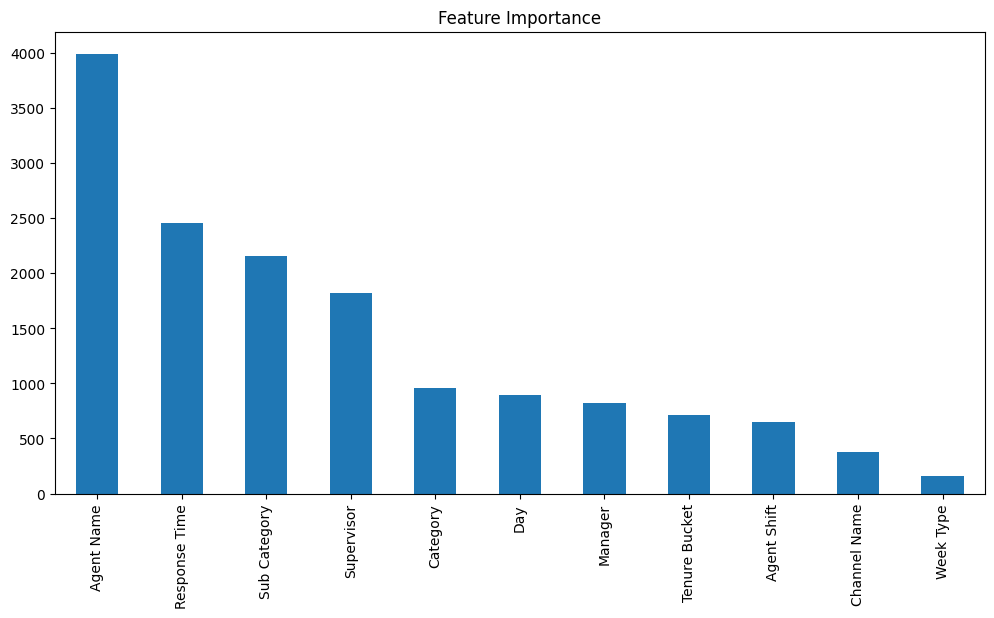

In [ ]:
# Plot feature importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Feature Importance")
plt.show()

In [ ]:
#Dropping week type as it has very less significance
df_encoded = df_encoded.drop(columns=['Week Type'])

## 8. Data Transformation

Since I'am planning to use tree-based models (like LightGBM, CatBoost, or Random Forest) for multi-class classification, It is not nessecary for me to do transformation.

# 7. ML Model Implementation

##ML Model - 1

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_model

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

###1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.6949714817832615
Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.01      0.03      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.70      1.00      0.82     11924

    accuracy                           0.69     17182
   macro avg       0.26      0.20      0.17     17182
weighted avg       0.56      0.69      0.57     17182



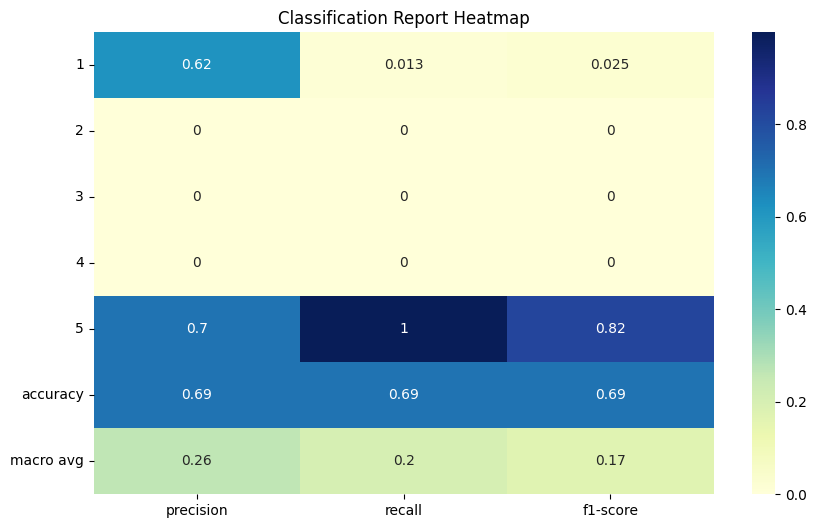

In [ ]:
# Visualizing evaluation Metric Score chart
# Convert classification report to a DataFrame
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()

# Plot
plt.figure(figsize=(10, 6))
sb.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
plt.title("Classification Report Heatmap")
plt.show()

###2. Cross- Validation & Hyperparameter Tuning

In [ ]:
param_dist = {
    'n_estimators': [50],         # lower trees
    'max_depth': [10],            # small depth
    'min_samples_split': [2],     # default
    'min_samples_leaf': [1],      # default
    'max_features': ['sqrt'],     # good for RF
    'bootstrap': [True]           # default
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Randomized Search with 1 candidate (basically default test)
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=1,          # only 1 combination
    cv=2,              # just 2-fold CV for speed
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_random.fit(X_train, y_train)

# Best model
best_rf = rf_random.best_estimator_

# Predict
y_pred_best = best_rf.predict(X_test)

In [ ]:
# Evaluation
rf_accuracy=accuracy_score(y_test, y_pred_best)
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nBest Params:", rf_random.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Tuned Accuracy: 0.6953206844372017

Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.01      0.03      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.70      1.00      0.82     11924

    accuracy                           0.69     17182
   macro avg       0.26      0.20      0.17     17182
weighted avg       0.56      0.69      0.57     17182



####Which hyperparameter optimization technique have you used and why?

####Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

## ML Model - 2

In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
lgbm

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 68725, number of used features: 11
[LightGBM] [Info] Start training from score -2.034668
[LightGBM] [Info] Start training from score -4.203471
[LightGBM] [Info] Start training from score -3.514226
[LightGBM] [Info] Start training from score -2.035670
[LightGBM] [Info] Start training from score -0.365328


LGBMClassifier(random_state=42)

### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n",  classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.6961936910720522

Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.05      0.10      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.70      0.99      0.82     11924

    accuracy                           0.70     17182
   macro avg       0.24      0.21      0.18     17182
weighted avg       0.55      0.70      0.58     17182



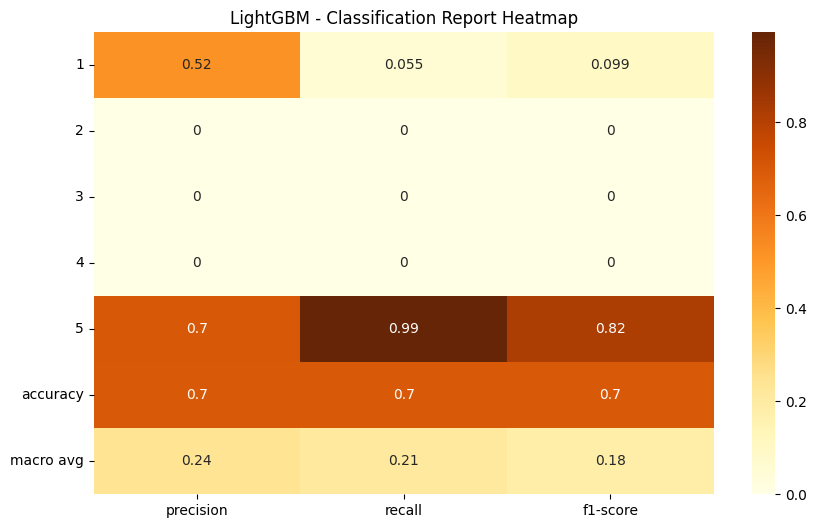

In [ ]:

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sb.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='YlOrBr')
plt.title("LightGBM - Classification Report Heatmap")
plt.show()

###2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# Ultra-light param grid
param_grid = {
    'n_estimators': [50],              # Reduced trees
    'learning_rate': [0.1],            # Default good start
    'max_depth': [10],                 # Moderate depth
    'num_leaves': [31],                # Default
    'min_child_samples': [20],         # Default
    'subsample': [0.8],                # Some randomness
    'colsample_bytree': [0.8],         # Some randomness
    'reg_alpha': [0],                  # No regularization
    'reg_lambda': [0]                  # No regularization
}

# Randomized search with just 1 config, 2-fold CV
lgbm_random = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=1,             # Only 1 combination
    cv=2,                 # Just 2-fold CV
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit model
lgbm_random.fit(X_train, y_train)

# Best model
best_lgbm = lgbm_random.best_estimator_

# Predict
y_pred_best = best_lgbm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 68725, number of used features: 11
[LightGBM] [Info] Start training from score -2.034668
[LightGBM] [Info] Start training from score -4.203471
[LightGBM] [Info] Start training from score -3.514226
[LightGBM] [Info] Start training from score -2.035670
[LightGBM] [Info] Start training from score -0.365328


In [ ]:
# Evaluation
lgbm_accuracy=accuracy_score(y_test, y_pred_best)
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nBest Params:", lgbm_random.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, zero_division=0))

Tuned Accuracy: 0.6963100919566989

Best Params: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 50, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.04      0.07      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.70      1.00      0.82     11924

    accuracy                           0.70     17182
   macro avg       0.25      0.21      0.18     17182
weighted avg       0.56      0.70      0.58     17182



Which hyperparameter optimization technique have you used and why?

Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

## ML Model - 3

In [ ]:
# ✅ Ensure column names are correct
print("X_train.columns:", X_train.columns.tolist())

X_train.columns: ['Channel Name', 'Category', 'Sub Category', 'Agent Name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift', 'Response Time', 'Day', 'Week Type']


In [ ]:
cat_features = ['Channel Name', 'Category', 'Supervisor', 'Agent Shift']

# Train the model
catb_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=False
)
catb_model.fit(X_train, y_train, cat_features=cat_features)

catb_model.save_model("catboost_model.cbm")


### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# --- Predict and evaluate ---
y_pred = catb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.6955534862064952
Classification Report:
               precision    recall  f1-score   support

           1       0.55      0.02      0.04      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.70      1.00      0.82     11924

    accuracy                           0.70     17182
   macro avg       0.25      0.20      0.17     17182
weighted avg       0.56      0.70      0.57     17182



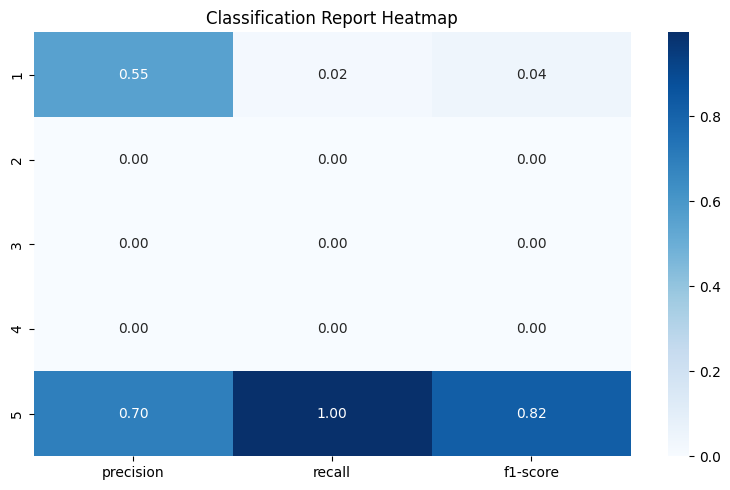

In [ ]:
# --- Classification report heatmap ---
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
class_metrics = {k: v for k, v in report_dict.items() if k.isdigit()}
report_df = pd.DataFrame(class_metrics).T[['precision', 'recall', 'f1-score']]

plt.figure(figsize=(8, 5))
sb.heatmap(report_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.show()



### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# Subsample for speed
X_sub = X_train.sample(frac=0.2, random_state=42)
y_sub = y_train.loc[X_sub.index]

# Light grid
param_dist = {
    'iterations': [100],
    'depth': [4, 6],
    'learning_rate': [0.05],
    'l2_leaf_reg': [3],
}

# CatBoost model
base_model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=0,
    cat_features=cat_features
)

# Fit parameters (for early stopping)
fit_params = {
    "early_stopping_rounds": 10,
    "eval_set": [(X_test, y_test)]
}

# Randomized search (super fast)
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=2,            # Only 2 combinations
    scoring='accuracy',
    cv=2,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Run search
random_search.fit(X_sub, y_sub, **fit_params)

# Best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [ ]:
print("Best Params:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
catB_accuracy=accuracy_score(y_test, y_pred)

Best Params: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}
Accuracy: 0.6939820742637645
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.69      1.00      0.82     11924

    accuracy                           0.69     17182
   macro avg       0.14      0.20      0.16     17182
weighted avg       0.48      0.69      0.57     17182



Which hyperparameter optimization technique have you used and why?


Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.


##Comparisions of all models

In [ ]:
result = pd.DataFrame({
    "Model": ["RandomForest", "LGBM", "CatBoost"],
    "Accuracy": [rf_accuracy, lgbm_accuracy, catB_accuracy]
})
result

,Model,Accuracy
0,RandomForest,0.695321
1,LGBM,0.696310
2,CatBoost,0.693982


#8. Saving and Deployment

## 1.Saving

In [ ]:
# Save model, column order, and cat features (IMPORTANT!)
catb_model.save_model("catboost_model.cbm")
joblib.dump(X_train.columns.tolist(), "model_columns.pkl")
joblib.dump(cat_features, "cat_features.pkl")  # <-- New!

['cat_features.pkl']

# Conclusion

In conclusion, this project successfully built a machine learning pipeline to predict CSAT scores using real-world customer support data. Through extensive data cleaning, feature engineering, and modeling, we uncovered key patterns influencing customer satisfaction—especially the impact of response time and support shifts. While high class imbalance posed challenges, the models provided valuable insights, with Random Forest achieving 69% accuracy. The deployed Streamlit app allows for practical use by business teams to anticipate customer satisfaction. Future enhancements could include NLP analysis of customer remarks and deeper agent profiling to improve predictive power and ultimately boost customer service quality.